# 4.1.	Séries temporais das concentrações de poluentes atmosféricos no Brasil 

### 4.1.1 Explorando a planilha com as séries temporais de cada estação

In [1]:
import scripts.timeSeriesFigures as tsf
import pandas as pd
df = pd.read_csv('https://lcqar.ufsc.br/files/RS0009_MP10.csv')
df.head()

,ANO,MES,DIA,HORA,CODIGO,DATETIME,POLUENTE,COD_POLUENTE,VALOR,UNIDADE,TESTACAO,TIPO
0,2023,1,1,00:00:00,RS0009,NaN,MP10,NaN,25.78,micro-g/m³,Referencia,Automatica
1,2023,1,1,01:00:00,RS0009,NaN,MP10,NaN,31.66,micro-g/m³,Referencia,Automatica
2,2023,1,1,02:00:00,RS0009,NaN,MP10,NaN,28.67,micro-g/m³,Referencia,Automatica
3,2023,1,1,03:00:00,RS0009,NaN,MP10,NaN,28.82,micro-g/m³,Referencia,Automatica
4,2023,1,1,04:00:00,RS0009,NaN,MP10,NaN,23.11,micro-g/m³,Referencia,Automatica


### 4.1.2 Visualizando as séries temporais de cada estação

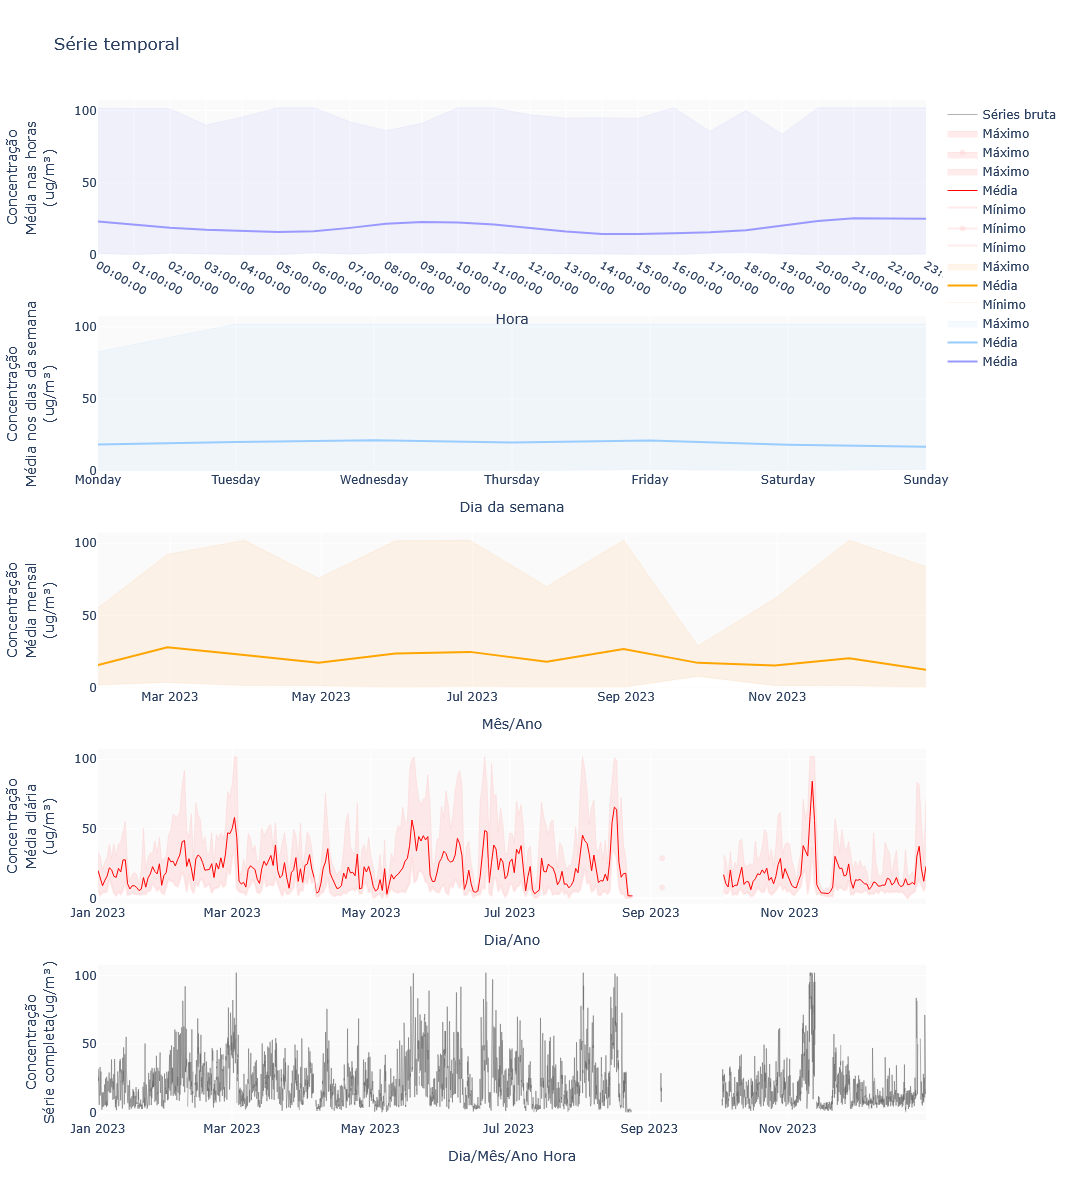

In [2]:
import scripts.timeSeriesFigures as tsf
import pandas as pd
df = pd.read_csv('https://lcqar.ufsc.br/files/RS0009_MP10.csv')
tsf.iterative_timeseries(df)

In [6]:
import os
import pandas as pd
import json
from IPython.display import display, HTML

# Load CSV

# Caminho para a pasta de dados
rootPath = os.path.dirname(os.getcwd())

# Lendo o csv
df = pd.read_csv(rootPath+'/data/Monitoramento_QAr_BR.csv',encoding = 'unicode_escape')

# Group pollutants by station
station_pollutants = df.groupby("ID_OEMA")["POLUENTE"].apply(list).to_dict()

# JSON for JS
js_data = json.dumps(station_pollutants)

# Default station and pollutant
initial_station = list(station_pollutants.keys())[0]
initial_pollutant = station_pollutants[initial_station][0]

# Generate HTML/JS block
html_block = f"""
<script>
const stationPollutants = {js_data};

function updatePollutants() {{
    const station = document.getElementById('station-select').value;
    const pollutantSelect = document.getElementById('pollutant-select');
    
    // Clear existing options
    pollutantSelect.innerHTML = '';

    // Add new options for selected station
    stationPollutants[station].forEach(p => {{
        const option = document.createElement('option');
        option.value = p;
        option.text = p;
        pollutantSelect.appendChild(option);
    }});

    // Show first available pollutant by default
    updateFigure();
}}

function updateFigure() {{
    const station = document.getElementById('station-select').value;
    const pollutant = document.getElementById('pollutant-select').value;
    const filename = `../_static/${{station}}_${{pollutant}}.html`;
    document.getElementById('figure-frame').src = filename;
}}
</script>

<label for="station-select">Estação:</label>
<select id="station-select" onchange="updatePollutants()">
  {''.join([f'<option value="{s}">{s}</option>' for s in station_pollutants])}
</select>

<label for="pollutant-select" style="margin-left:20px;">Poluente:</label>
<select id="pollutant-select" onchange="updateFigure()">
  {''.join([f'<option value="{p}">{p}</option>' for p in station_pollutants[initial_station]])}
</select>

<br><br>

<iframe
  id="figure-frame"
  src="../_static/{initial_station}_{initial_pollutant}.html"
  width="100%"
  height="600"
  style="border: 1px solid #ccc;">
</iframe>
"""

display(HTML(html_block))


### 4.1.2 Recorte e visualização customizada das séries temporais de cada estação

In [32]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from itables import show
import itables.options as opt
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import os
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

# Configure itables
opt.lengthMenu = [10, 25, 50, 100]
opt.scrollX = True

# Settings
DATA_FOLDER = 'https://lcqar.ufsc.br/files/2023'  # adjust as needed
#AVAILABLE_STATIONS = ['RS0009', 'station2', 'station3']
#AVAILABLE_POLLUTANTS = ['MP10', 'PM2.5', 'CO', 'NO2']

# Lendo o csv
aqmData = pd.read_csv('https://lcqar.ufsc.br/files/2023/Monitoramento_QAr_BR_teste.csv',encoding = 'unicode_escape')

# Create dict: station -> list of pollutants
station_pollutants = aqmData.groupby("ID_MMA")["POLUENTE"].unique().apply(list).to_dict()
# Set station list
AVAILABLE_STATIONS = sorted(station_pollutants.keys())

# Widgets
station_dropdown = widgets.Dropdown(options=AVAILABLE_STATIONS, description='Station:')
pollutant_dropdown = widgets.Dropdown(description='Pollutant:')
load_button = widgets.Button(description="Load CSV", button_style='primary')
start_date = widgets.DatePicker(description='Start date:')
end_date = widgets.DatePicker(description='End date:')
filter_button = widgets.Button(description="Apply Filter", button_style='info', disabled=True)
csv_button = widgets.Button(description="Download Filtered CSV", button_style='success', disabled=True)

# Output widgets
output_error = widgets.Output()
output_table = widgets.Output()
output_plot = widgets.Output()
output_download = widgets.Output()

# DataFrames
loaded_df = pd.DataFrame()
filtered_df = pd.DataFrame()

def tratar_dados(df):
    # Convert all to string first
    hour_str = df['HORA'].astype(str)
    df['datetime'] = pd.to_datetime({
      'year': df['ANO'],
      'month': df['MES'],
      'day': df['DIA'],
      'hour': df['HORA'],        
    }, errors='coerce')
    # Substitui , por . 
    df['VALOR'] = df['VALOR'].replace(',', '.', regex=True).copy()
    # Converte para float, forçando erro para NaN
    df['VALOR'] = pd.to_numeric(df['VALOR'], errors='coerce').copy()
    # Transforma valores negativos em NaN
    df.loc[df['VALOR'] < 0, 'VALOR'] = np.nan
    #print(df)
    time_range = pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='h').to_series(name='datetime')
    df = pd.merge(time_range, df,how='left')
    #df = df.set_index('datetime', drop=False)
    df['datetime'] = pd.to_datetime(df['datetime']).copy()
    return df
    
def split_nan_segments(x, y):
    """Splits x and y into segments where y is not NaN"""
    segments = []
    x = np.array(x)
    y = np.array(y)
    
    isnan = np.isnan(y)
    start = 0
    for i in range(1, len(y)):
        if isnan[i] and not isnan[i-1]:
            segments.append((x[start:i], y[start:i]))
            start = i + 1
        elif not isnan[i] and isnan[i-1]:
            start = i
    if not isnan[-1]:
        segments.append((x[start:], y[start:]))
    return segments
    
def iterative_raw_timeseries(df):
    df = tratar_dados(df)
    dates = df['datetime']
    # Create the figure
    #fig = go.Figure()
    fig = make_subplots(rows=1, cols=1) 
    # raw
    
    segments = split_nan_segments(df['datetime'], df.VALOR)
    for seg_x, seg_y in segments:
        fig.add_trace(go.Scatter(
            x=seg_x,
            y=seg_y,
            #fill='tozeroy',
            line=dict(color='rgba(0, 0, 0, 1.5)', width=1),
            #fillcolor='rgba(255,255,255,1)',
            #fillcolor='rgba(153, 153, 255,0.1)',
            showlegend=False,
            name='Concentração',
            mode='lines',
            connectgaps=False
        ))
        
    # Update layout for better presentation
    fig.update_layout(
        title='Série temporal',
        hovermode='x unified', # Shows hover info for all traces at a given x-coordinate
        height=600, width=800,
        plot_bgcolor='rgba(0.8,0.8,0.8,0.2)',
        yaxis_range=[0, df.VALOR.max()*1.1])
    
    unidade = '(ug/m³)'
    fig.update_yaxes(title_text="Concentração<br>Série completa"+unidade, row=5, col=1)
    fig.update_xaxes(title_text="Dia/Mês/Ano Hora")
    
    #fig.add_hrect(y0=50, y1=df.VALOR.max(), line_width=0, 
    #              layer="below",fillcolor="red", opacity=.3) 
    
    return fig

def update_pollutants(change):
    # Get current station from widget (robust to both observer and manual call)
    selected_station = change['new'] if isinstance(change, dict) else station_dropdown.value
    
    # Get corresponding pollutants
    new_pollutants = station_pollutants.get(selected_station, [])
    
    # Save old value to restore if possible
    old_value = pollutant_dropdown.value

    # Update options with a *copy* to force change detection
    pollutant_dropdown.options = list(new_pollutants)
    
    # Set default or preserve old value if valid
    if old_value in new_pollutants:
        pollutant_dropdown.value = old_value
    elif new_pollutants:
        pollutant_dropdown.value = new_pollutants[0]
    else:
        pollutant_dropdown.value = None
        
# Function to update UI outputs (table, plot)
def update_outputs():
    with output_table:
        clear_output()
        display(filtered_df)  # substitui show()
    with output_plot:
        clear_output()
        if not filtered_df.empty and 'datetime' in filtered_df.columns:
            fig = iterative_raw_timeseries(filtered_df)
            display(fig)  # substitui fig.show()
    csv_button.disabled = filtered_df.empty

# Load button action
def on_load_clicked(_):
    global loaded_df, filtered_df
    with output_error, output_table, output_plot, output_download:
        clear_output()
        station = station_dropdown.value
        pollutant = pollutant_dropdown.value
        filename = f"{station}.csv"
        filepath = os.path.join(DATA_FOLDER+'/'+pollutant+'/', filename)
        
        loaded_df = pd.read_csv(filepath)
        loaded_df = tratar_dados(loaded_df)
        #print(loaded_df.datetime.head())
        filtered_df[:] = loaded_df.copy()

        if not loaded_df.empty and 'datetime' in loaded_df.columns:
            start_date.value = loaded_df['datetime'].min().date()
            end_date.value = loaded_df['datetime'].max().date()
        filter_button.disabled = False
        update_outputs()

# Date filter action
def on_filter_clicked(_):
    global filtered_df
    if 'datetime' not in loaded_df.columns:
        return
    mask = (loaded_df['datetime'].dt.date >= start_date.value) & (loaded_df['datetime'].dt.date <= end_date.value)
    filtered_df = loaded_df.loc[mask]
    update_outputs()

# CSV download button
def on_csv_clicked(_):
    with output_download:
        clear_output()
        csv_buffer = BytesIO()
        filtered_df.to_csv(csv_buffer, index=False)
        b64 = base64.b64encode(csv_buffer.getvalue()).decode()
        filename = f"{station_dropdown.value}_{pollutant_dropdown.value}_filtered.csv"
        payload = f"data:text/csv;base64,{b64}"
        html = f"""
        <a id="download_link" download="{filename}" href="{payload}"></a>
        <script>document.getElementById('download_link').click();</script>
        """
        display(HTML(html))

# Event bindings
load_button.on_click(on_load_clicked)
filter_button.on_click(on_filter_clicked)
csv_button.on_click(on_csv_clicked)


# Layout
ui_select = widgets.HBox([station_dropdown, pollutant_dropdown, load_button])
ui_dates = widgets.HBox([start_date, end_date, filter_button])
ui_download = widgets.HBox([csv_button])

station_dropdown.observe(update_pollutants, names='value')
update_pollutants({'new': station_dropdown.value})  # Trigger initial update


display(ui_select, ui_dates, output_error, output_table, output_plot, ui_download, output_download)

Output()

Output()

Output()

Output()

### OPÇÃO PARA RODAR SEM OS WIDGETS


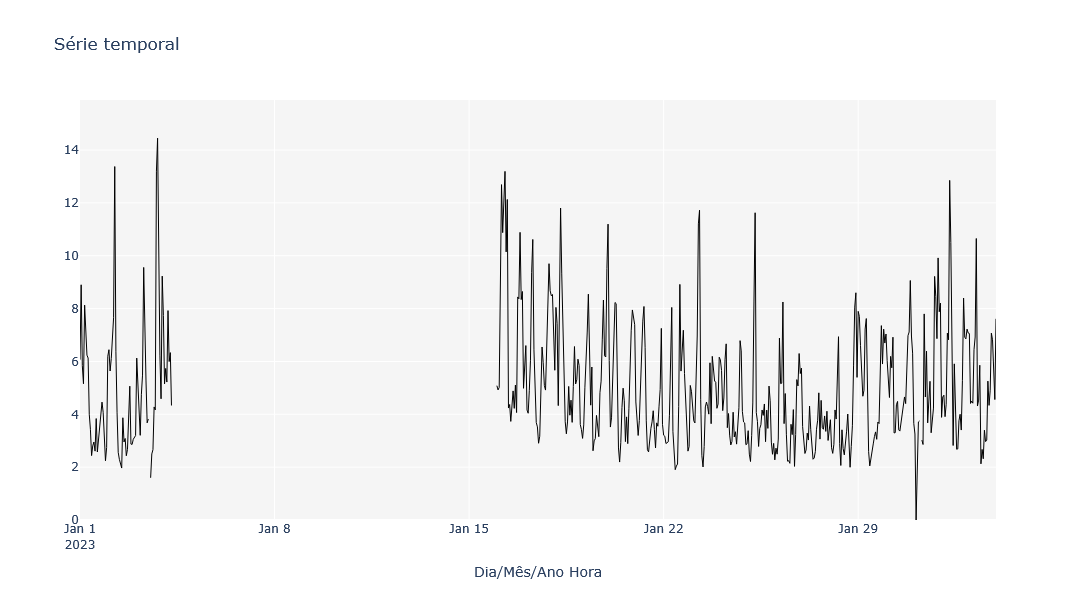


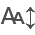

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [34]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from itables import show
import itables.options as opt
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import os
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

filename = 'BA0007RA004.csv'
pollutant = 'NO2'
start_date = pd.to_datetime('2023-01-01').date()
end_date = pd.to_datetime('2023-02-02').date()


# Settings
DATA_FOLDER = 'https://lcqar.ufsc.br/files/2023'  # adjust as needed
#AVAILABLE_STATIONS = ['RS0009', 'station2', 'station3']
#AVAILABLE_POLLUTANTS = ['MP10', 'PM2.5', 'CO', 'NO2']

# Lendo o csv
aqmData = pd.read_csv('https://lcqar.ufsc.br/files/2023/Monitoramento_QAr_BR_teste.csv',encoding = 'unicode_escape')


def tratar_dados(df):
    # Convert all to string first
    hour_str = df['HORA'].astype(str)
    df['datetime'] = pd.to_datetime({
      'year': df['ANO'],
      'month': df['MES'],
      'day': df['DIA'],
      'hour': df['HORA'],        
    }, errors='coerce')
    # Substitui , por . 
    df['VALOR'] = df['VALOR'].replace(',', '.', regex=True).copy()
    # Converte para float, forçando erro para NaN
    df['VALOR'] = pd.to_numeric(df['VALOR'], errors='coerce').copy()
    # Transforma valores negativos em NaN
    df.loc[df['VALOR'] < 0, 'VALOR'] = np.nan
    #print(df)
    time_range = pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='h').to_series(name='datetime')
    df = pd.merge(time_range, df,how='left')
    #df = df.set_index('datetime', drop=False)
    df['datetime'] = pd.to_datetime(df['datetime']).copy()
    return df
    
def split_nan_segments(x, y):
    """Splits x and y into segments where y is not NaN"""
    segments = []
    x = np.array(x)
    y = np.array(y)
    
    isnan = np.isnan(y)
    start = 0
    for i in range(1, len(y)):
        if isnan[i] and not isnan[i-1]:
            segments.append((x[start:i], y[start:i]))
            start = i + 1
        elif not isnan[i] and isnan[i-1]:
            start = i
    if not isnan[-1]:
        segments.append((x[start:], y[start:]))
    return segments
    
def iterative_raw_timeseries(df):
    df = tratar_dados(df)
    dates = df['datetime']
    # Create the figure
    #fig = go.Figure()
    fig = make_subplots(rows=1, cols=1) 
    # raw
    
    segments = split_nan_segments(df['datetime'], df.VALOR)
    for seg_x, seg_y in segments:
        fig.add_trace(go.Scatter(
            x=seg_x,
            y=seg_y,
            #fill='tozeroy',
            line=dict(color='rgba(0, 0, 0, 1.5)', width=1),
            #fillcolor='rgba(255,255,255,1)',
            #fillcolor='rgba(153, 153, 255,0.1)',
            showlegend=False,
            name='Concentração',
            mode='lines',
            connectgaps=False
        ))
        
    # Update layout for better presentation
    fig.update_layout(
        title='Série temporal',
        hovermode='x unified', # Shows hover info for all traces at a given x-coordinate
        height=600, width=800,
        plot_bgcolor='rgba(0.8,0.8,0.8,0.2)',
        yaxis_range=[0, df.VALOR.max()*1.1])
    
    unidade = '(ug/m³)'
    fig.update_yaxes(title_text="Concentração<br>Série completa"+unidade, row=5, col=1)
    fig.update_xaxes(title_text="Dia/Mês/Ano Hora")
    
    #fig.add_hrect(y0=50, y1=df.VALOR.max(), line_width=0, 
    #              layer="below",fillcolor="red", opacity=.3) 
    
    return fig

filepath = os.path.join(DATA_FOLDER+'/'+pollutant+'/', filename)
loaded_df = pd.read_csv(filepath)
loaded_df = tratar_dados(loaded_df)
mask = (loaded_df['datetime'].dt.date >= start_date) & (loaded_df['datetime'].dt.date <= end_date)
loaded_df = loaded_df.loc[mask]
fig = iterative_raw_timeseries(loaded_df)
display(fig)

import os
import pandas as pd
from IPython.display import display, HTML
from typing import List
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from itables import init_notebook_mode, show
import itables.options as opt
init_notebook_mode(all_interactive=True)
opt.maxBytes = 0
# Configure global options
opt.classes = "display compact stripe"
opt.columnDefs = [{"targets": "_all", "className": "dt-rigth"},   
                  {"targets": [0,1],  # First column
                   "width": "60px",  # or "10%" if you prefer relative size
                   "className": "dt-right"  # optional: left-align
                  },]  # Align text right
opt.style = "font-size: 11px; white-space: normal;div.dt-buttons button {font-size: 10px !important; padding: 4px 6px;"  # Apply font size and enable wrapping
opt.lengthMenu = [5, 10, 25]
show(loaded_df, 
         buttons=["copyHtml5", "csvHtml5", "excelHtml5","columnsToggle"],
         layout={"top1": "searchPanes"},
         searchPanes={"layout": "columns-3", "cascadePanes": True, "columns": [0,1,2,3]},
         allow_html=True,
         keys=True,
         escape=False,
         index=False,)